In [ ]:
!pip install -q roboflow ultralytics==8.2.0 opencv-python-headless matplotlib tqdm torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MMFZWHhSvylkZHBxlS7M")
project = rf.workspace("imit-h5ows").project("soil-detection-l0ngo")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
import os, random, shutil, glob, time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import files

Helper functions and paths

In [ ]:
def count_images(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder) if f.lower().endswith((".jpg",".jpeg",".png"))])

train_img_path = os.path.join(dataset.location, "train", "images")
valid_img_path = os.path.join(dataset.location, "valid", "images")
test_img_path  = os.path.join(dataset.location, "test",  "images")

print("\n--- IMAGE COUNTS (before preprocessing) ---")
print("Train:", count_images(train_img_path))
print("Valid:", count_images(valid_img_path))
print("Test: ", count_images(test_img_path))


--- IMAGE COUNTS (before preprocessing) ---
Train: 199
Valid: 58
Test:  28


Preprocessing functions

In [ ]:
def hist_equalize(img):
    # operate on Y channel
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def random_brightness(img, limit=25):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.int32)
    val = random.randint(-limit, limit)
    hsv[:,:,2] = np.clip(hsv[:,:,2] + val, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def sharpen(img):
    k = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
    return cv2.filter2D(img, -1, k)

def flip_h(img):
    return cv2.flip(img, 1)

def rotate_img(img, angle_range=(-8,8)):
    ang = random.uniform(angle_range[0], angle_range[1])
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), ang, 1)
    return cv2.warpAffine(img, M, (w, h))

def resize(img, size=(256,256)):
    return cv2.resize(img, size)

Apply preprocessing and save into processed folder

In [ ]:
processed_root = os.path.join(dataset.location, "preprocessed_no_masks")
if os.path.exists(processed_root):
    shutil.rmtree(processed_root)
for s in ["train","valid","test"]:
    os.makedirs(os.path.join(processed_root, s, "images"), exist_ok=True)

print("\nApplying preprocessing to images (this may take a few minutes)...")
processed_counts = {"train":0,"valid":0,"test":0}
for s in ["train","valid","test"]:
    src_folder = os.path.join(dataset.location, s, "images")
    dst_folder = os.path.join(processed_root, s, "images")
    files = [f for f in os.listdir(src_folder) if f.lower().endswith((".jpg",".jpeg",".png"))]
    print(f"\nProcessing set: {s} ({len(files)} images)")
    for fn in tqdm(files):
        src_img_path = os.path.join(src_folder, fn)
        dst_img_path = os.path.join(dst_folder, fn)
        img = cv2.imread(src_img_path)
        if img is None:
            continue

        # preprocessing pipeline
        img = hist_equalize(img)
        img = random_brightness(img, limit=25)
        img = sharpen(img)

        if random.random() > 0.5:
            img = flip_h(img)

        img = rotate_img(img, angle_range=(-6,6))
        img = resize(img, (256,256))

        # save as JPEG to dst
        cv2.imwrite(dst_img_path, img)
        processed_counts[s] += 1

print("\nPreprocessing finished. Processed counts:", processed_counts)


Applying preprocessing to images (this may take a few minutes)...

Processing set: train (199 images)


100%|██████████| 199/199 [00:03<00:00, 56.28it/s]



Processing set: valid (58 images)


100%|██████████| 58/58 [00:01<00:00, 56.28it/s]



Processing set: test (28 images)


100%|██████████| 28/28 [00:00<00:00, 40.31it/s]


Preprocessing finished. Processed counts: {'train': 199, 'valid': 58, 'test': 28}


Display counts before/after

In [ ]:
print("\n--- SUMMARY IMAGE COUNTS ---")
print("Before preprocessing:")
print(" Train:", count_images(train_img_path))
print(" Valid:", count_images(valid_img_path))
print(" Test: ", count_images(test_img_path))
print("\nAfter preprocessing (processed images):")
print(" Train processed:", processed_counts["train"])
print(" Valid processed:", processed_counts["valid"])
print(" Test processed: ", processed_counts["test"])


--- SUMMARY IMAGE COUNTS ---
Before preprocessing:
 Train: 199
 Valid: 58
 Test:  28

After preprocessing (processed images):
 Train processed: 199
 Valid processed: 58
 Test processed:  28


Display 5 random samples

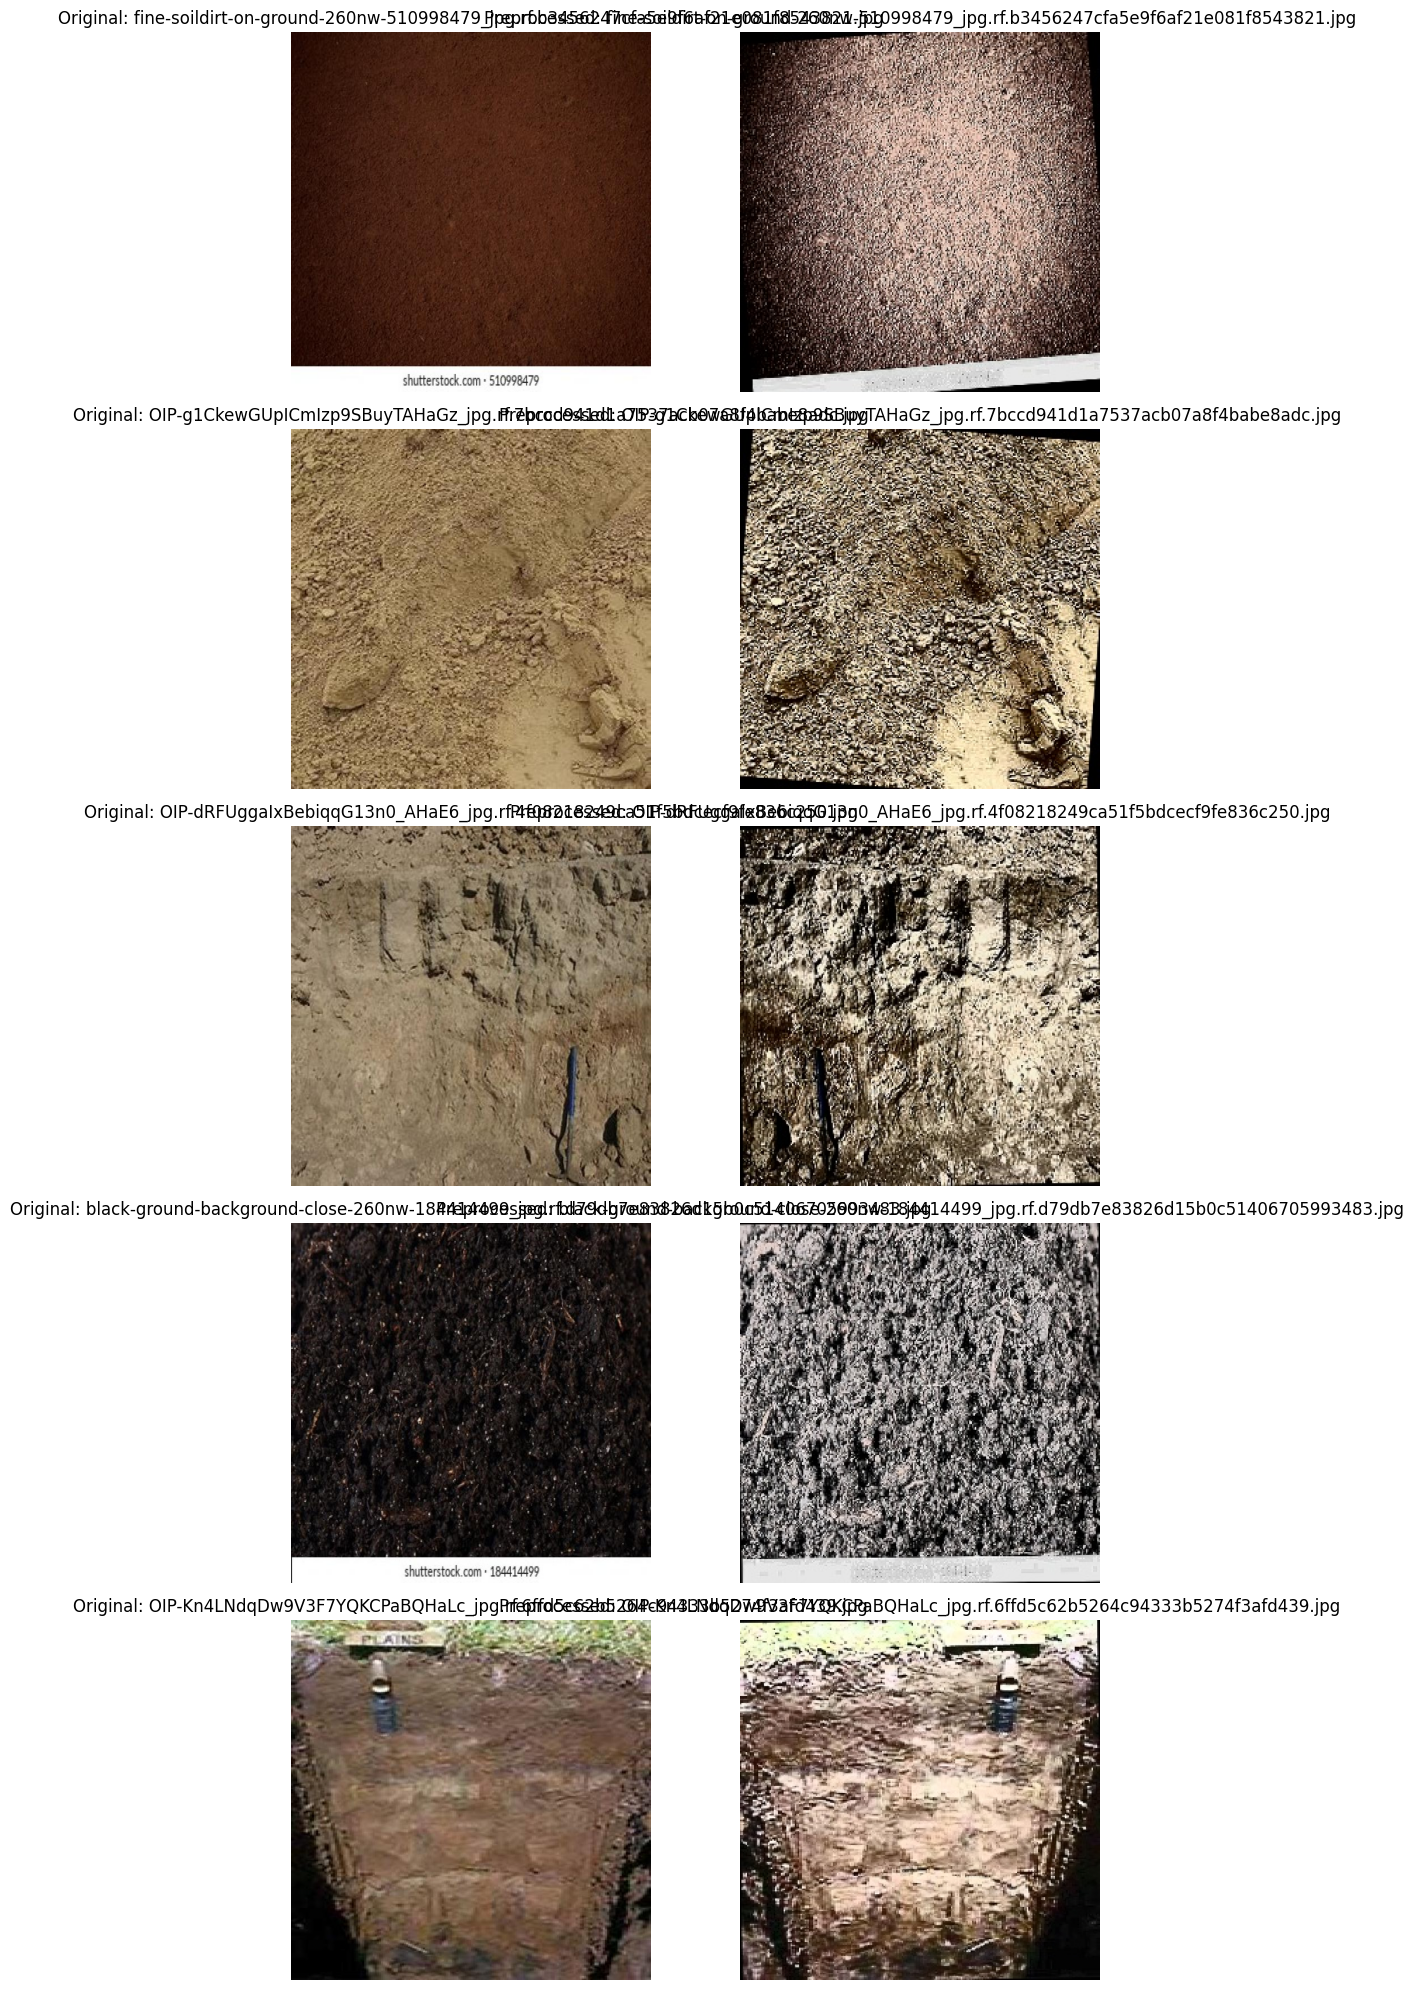

In [ ]:
def show_samples(n=5):
    orig_files = sorted([f for f in os.listdir(train_img_path) if f.lower().endswith((".jpg",".jpeg",".png"))])
    proc_files = sorted([f for f in os.listdir(os.path.join(processed_root,"train","images")) if f.lower().endswith((".jpg",".jpeg",".png"))])
    n_show = min(n, len(proc_files), len(orig_files))
    indices = random.sample(range(len(proc_files)), n_show)

    plt.figure(figsize=(10, 4 * n_show))
    plot_i = 1
    for idx in indices:
        fn = proc_files[idx]
        orig = cv2.cvtColor(cv2.imread(os.path.join(train_img_path, fn)), cv2.COLOR_BGR2RGB)
        proc = cv2.cvtColor(cv2.imread(os.path.join(processed_root, "train", "images", fn)), cv2.COLOR_BGR2RGB)

        plt.subplot(n_show,2,plot_i); plt.imshow(orig); plt.title(f"Original: {fn}"); plt.axis("off"); plot_i+=1
        plt.subplot(n_show,2,plot_i); plt.imshow(proc); plt.title(f"Preprocessed: {fn}"); plt.axis("off"); plot_i+=1
    plt.tight_layout()
    plt.show()

show_samples(5)

Simple class distribution (from detection label files) - counts per class in train labels

In [ ]:
def detection_class_counts(label_folder):
    counts = {}
    if not os.path.exists(label_folder):
        return counts
    files = [f for f in os.listdir(label_folder) if f.lower().endswith(".txt")]
    for fn in files:
        with open(os.path.join(label_folder, fn), "r") as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) == 0:
                    continue
                cls = int(float(parts[0]))
                counts[cls] = counts.get(cls, 0) + 1
    return counts

train_label_folder = os.path.join(dataset.location, "train", "labels")
label_counts = detection_class_counts(train_label_folder)
print("\nDetection label counts (train labels):", label_counts)


Detection label counts (train labels): {2: 30, 1: 60, 0: 78, 3: 75}


Create PyTorch Dataset & DataLoader for autoencoder training (input=image, target=image)

In [ ]:
class AutoImageDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted([os.path.join(folder,f) for f in os.listdir(folder) if f.lower().endswith((".jpg",".jpeg",".png"))])
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        img = np.array(img).astype(np.float32) / 255.0  # HWC, 0..1
        img = np.transpose(img, (2,0,1))  # CHW
        return torch.tensor(img, dtype=torch.float32), torch.tensor(img, dtype=torch.float32)

train_ds = AutoImageDataset(os.path.join(processed_root, "train", "images"))
val_ds   = AutoImageDataset(os.path.join(processed_root, "valid", "images"))
test_ds  = AutoImageDataset(os.path.join(processed_root, "test",  "images"))

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, num_workers=2, pin_memory=True)

print("\nAutoencoder dataset sizes (train/val/test):", len(train_ds), len(val_ds), len(test_ds))


Autoencoder dataset sizes (train/val/test): 199 58 28


Small U-Net autoencoder (encoder-decoder) — returns reconstructed image

In [ ]:
class UNetAuto(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.enc1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.Conv2d(32,32,3,padding=1), nn.ReLU())
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        # bottleneck
        self.bottleneck = nn.Sequential(nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.Conv2d(128,128,3,padding=1), nn.ReLU())
        # decoder
        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(64,64,3,padding=1), nn.ReLU(), nn.Conv2d(64,64,3,padding=1), nn.ReLU())
        self.up2 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(32,32,3,padding=1), nn.ReLU(), nn.Conv2d(32,32,3,padding=1), nn.ReLU())
        # final
        self.final = nn.Conv2d(32,3,1)  # reconstruct 3-channel image

    def forward(self, x):
        e1 = self.enc1(x)      # [B,32,H,W]
        e2 = self.enc2(self.pool(e1))  # [B,64,H/2,W/2]
        b  = self.bottleneck(self.pool(e2))  # [B,128,H/4,W/4]
        d1 = self.up1(b)      # [B,64,H/2,W/2]
        d1 = self.dec1(d1)
        d2 = self.up2(d1)     # [B,32,H,W]
        d2 = self.dec2(d2)
        out = torch.sigmoid(self.final(d2))  # 0..1
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
auto = UNetAuto().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(auto.parameters(), lr=1e-3)

# utility: PSNR
def psnr_batch(pred, target):
    mse = torch.mean((pred - target) ** 2, dim=[1,2,3])  # per image
    psnr = 10 * torch.log10(1.0 / (mse + 1e-8))
    return psnr.mean().item()

Using device: cpu


Train autoencoder (light training)

In [ ]:
epochs = 3
print("\nStarting U-Net autoencoder training (epochs =", epochs, ")")
for epoch in range(epochs):
    auto.train()
    total_loss = 0.0
    for imgs, targets in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = auto(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / max(1,len(train_loader))
    # quick validation PSNR
    auto.eval()
    with torch.no_grad():
        val_psnrs = []
        for i, (vimgs, vtargets) in enumerate(val_loader):
            vimgs = vimgs.to(device)
            vtargets = vtargets.to(device)
            preds = auto(vimgs)
            val_psnrs.append(psnr_batch(preds, vtargets))
            if i >= 9:  # limit for speed
                break
        mean_psnr = float(np.mean(val_psnrs)) if len(val_psnrs)>0 else 0.0
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.6f} - Val PSNR: {mean_psnr:.3f} dB")

# save autoencoder
torch.save(auto.state_dict(), "unet_auto_no_masks.pth")
print("Saved autoencoder weights -> unet_auto_no_masks.pth")


Starting U-Net autoencoder training (epochs = 3 )
Epoch 1/3 - Train Loss: 0.055182 - Val PSNR: 13.563 dB
Epoch 2/3 - Train Loss: 0.047811 - Val PSNR: 14.221 dB
Epoch 3/3 - Train Loss: 0.042493 - Val PSNR: 14.561 dB
Saved autoencoder weights -> unet_auto_no_masks.pth


Show reconstruction examples (3)

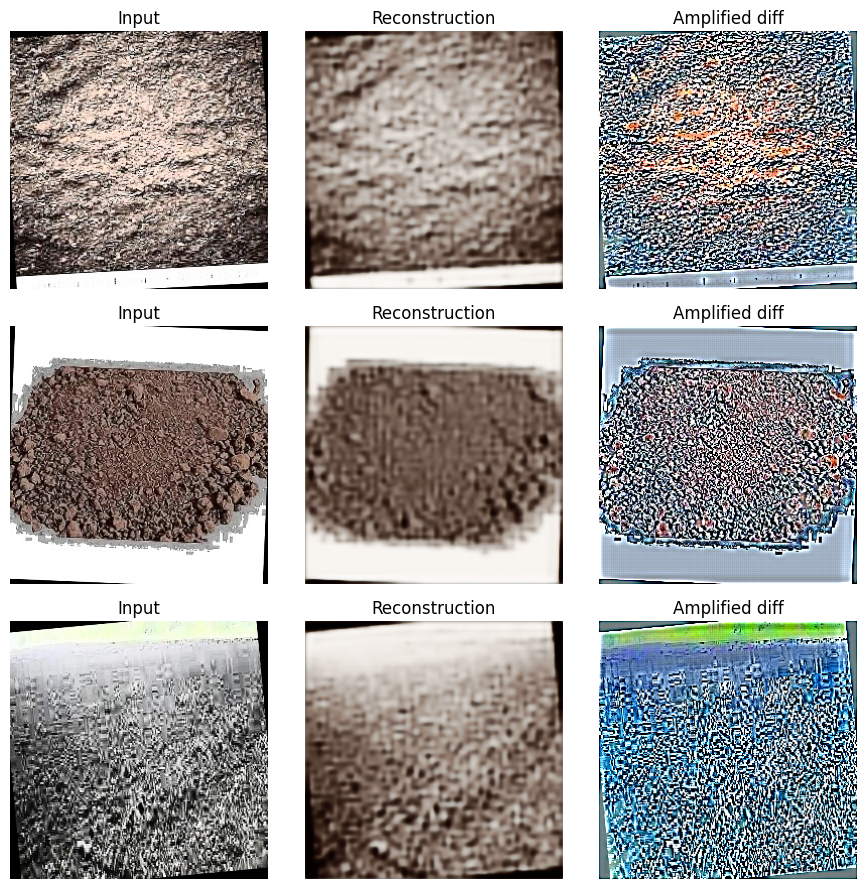

In [ ]:
auto.eval()
nvis = min(3, len(test_ds))
plt.figure(figsize=(9, 3*nvis))
for i in range(nvis):
    img, _ = test_ds[i]  # returns (img_tensor, img_tensor)
    with torch.no_grad():
        pred = auto(img.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()
    inp = img.numpy().transpose(1,2,0)
    out = pred.transpose(1,2,0)
    plt.subplot(nvis,3,i*3+1); plt.imshow(inp); plt.title("Input"); plt.axis("off")
    plt.subplot(nvis,3,i*3+2); plt.imshow(out); plt.title("Reconstruction"); plt.axis("off")
    diff = np.clip((inp - out) * 5 + 0.5, 0, 1)  # amplify differences visually
    plt.subplot(nvis,3,i*3+3); plt.imshow(diff); plt.title("Amplified diff"); plt.axis("off")
plt.tight_layout(); plt.show()

Identify all classes appearing in YOLO label files

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

labels_path = os.path.join(dataset.location, "train", "labels")
images_path = os.path.join(dataset.location, "train", "images")

class_counts = {}
sample_image_for_class = {}

label_files = [f for f in os.listdir(labels_path) if f.endswith(".txt")]

for lf in label_files:
    with open(os.path.join(labels_path, lf)) as f:
        lines = f.read().strip().split("\n")

    for line in lines:
        if line.strip() == "":
            continue
        cls = line.split()[0]  # class ID as string
        class_counts[cls] = class_counts.get(cls, 0) + 1

        # Save one sample image per class
        if cls not in sample_image_for_class:
            img_file = lf.replace(".txt", ".jpg")
            if not os.path.exists(os.path.join(images_path, img_file)):
                img_file = lf.replace(".txt", ".png")  # fallback
            full_img_path = os.path.join(images_path, img_file)
            if os.path.exists(full_img_path):
                sample_image_for_class[cls] = full_img_path


Display sample images (one per class)


=== CLASS DISTRIBUTION ===
Class 0: 78 boxes
Class 1: 60 boxes
Class 2: 30 boxes
Class 3: 75 boxes


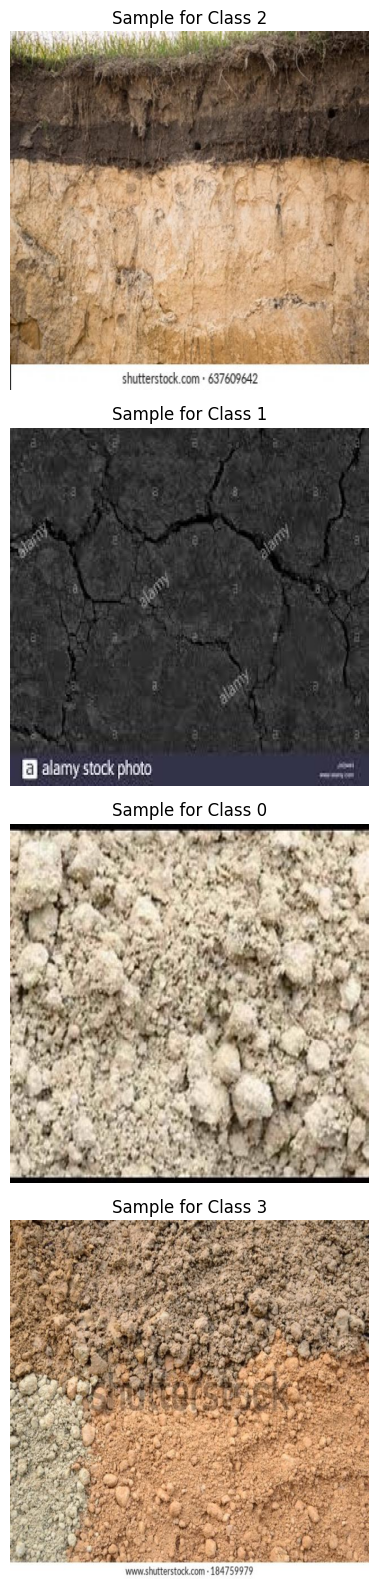

In [ ]:
print("\n=== CLASS DISTRIBUTION ===")
for cls in sorted(class_counts.keys(), key=lambda x: int(x)):
    print(f"Class {cls}: {class_counts[cls]} boxes")

num_classes = len(sample_image_for_class)

if num_classes > 0:
    plt.figure(figsize=(10, 4 * num_classes))
    idx = 1

    for cls, img_path in sample_image_for_class.items():
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(num_classes, 1, idx)
        plt.imshow(img)
        plt.title(f"Sample for Class {cls}")
        plt.axis("off")
        idx += 1

    plt.tight_layout()
    plt.show()
else:
    print("No classes found!")

Summary

In [ ]:
print("- Preprocessed images saved at:", processed_root)
print("- Processed counts:", processed_counts)
print("- Autoencoder weights:", "unet_auto_no_masks.pth")

- Preprocessed images saved at: /content/Soil-detection-3/preprocessed_no_masks
- Processed counts: {'train': 199, 'valid': 58, 'test': 28}
- Autoencoder weights: unet_auto_no_masks.pth


In [ ]:
from google.colab import files

zip_path = "/content/preprocessed_no_masks.zip"

files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>